In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [3]:
df = pd.read_csv("ecommerceDataset.csv", header=None)
print(np.sum(df[1].isna()))
df = df.dropna()
print(np.sum(df[1].isna()))
df.head()

1
0


,0,1
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


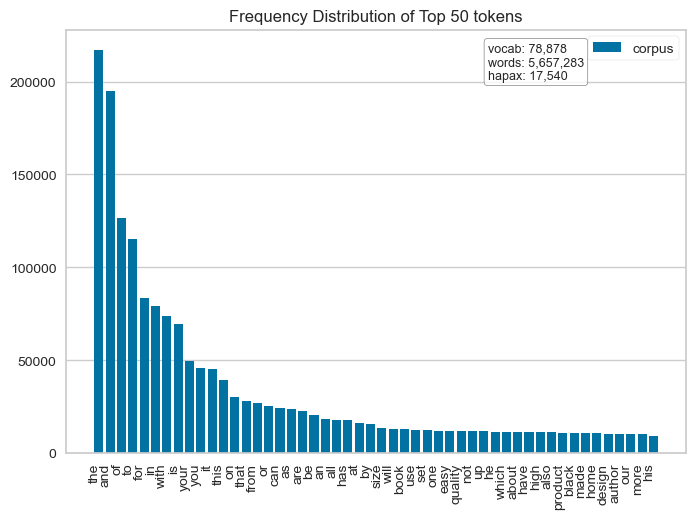

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [4]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df[1])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [6]:
text = df[1]
labels = df[0]

print(text.shape, labels.shape)

(50424,) (50424,)


In [9]:
# remove digits, @-mentions, links, stopwords
text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in nltk.corpus.stopwords.words()]))

text.shape

(50424,)

In [10]:
import pickle
with open("text.pkl", "wb") as f:
  pickle.dump(text, f)
with open("labels.pkl", "wb") as f:
  pickle.dump(labels, f)

In [2]:
import pickle
with open("text.pkl", "rb") as f:
  text = pickle.load(f)
with open("labels.pkl", "rb") as f:
  labels = pickle.load(f)

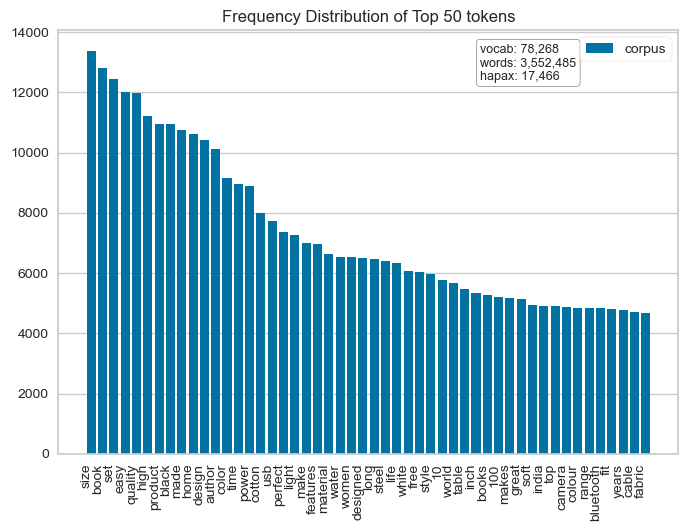

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [12]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
text = np.array(text)
labels = np.array(labels)

In [5]:
labels = np.array(labels)
text = np.array(text)
text = text[(labels == "Books") | (labels == "Electronics")]
labels = labels[(labels == "Books") | (labels == "Electronics")]

In [6]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [8]:
lengths = np.array(lengths)
X = np.array(X)

print(lengths)
print(lengths.shape)
print(np.sum(lengths < 64) / len(lengths))
print(np.sum(lengths < 64))
print(np.sum((lengths < 64) & (labels == "Electronics")))
print(np.sum((lengths < 64) & (labels == "Books")))

[177   6 110 ... 259 302  10]
(22441,)
0.38572256138318256
8656
2988
5668


In [9]:
X_electronics = X[(lengths < 64) & (labels == "Electronics")].tolist()
X_books = X[(lengths < 64) & (labels == "Books")].tolist()
X = X_electronics[:2000] + X_books[:2000]

y_electronics = labels[(lengths < 64) & (labels == "Electronics")].tolist()
y_books = labels[(lengths < 64) & (labels == "Books")].tolist()
y = y_electronics[:2000] + y_books[:2000]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [17]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [18]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.4738, -0.2803, -0.2252,  ..., -0.5440,  0.7136, -0.0855],
         [-0.2412,  0.0156, -0.2115,  ..., -0.5430,  0.6179,  0.2402],
         [-0.5992, -0.0850, -0.2734,  ..., -0.4937,  0.5401,  0.5064],
         ...,
         [-0.5111, -0.3645,  0.0510,  ..., -0.6311,  0.8011, -0.1296],
         [-0.5129, -0.3624,  0.0516,  ..., -0.6312,  0.8099, -0.1211],
         [-0.4881, -0.3325,  0.0279,  ..., -0.6259,  0.7941, -0.1357]],

        [[-0.0022,  0.2914,  0.4024,  ..., -0.6488,  0.2842, -0.3522],
         [-0.2651,  0.4191,  0.0921,  ..., -0.3796,  0.0959,  0.4956],
         [-0.2921,  0.4739,  0.3472,  ..., -0.3151,  0.0612,  0.4433],
         ...,
         [ 0.1515,  0.2160,  1.0116,  ..., -1.1728,  0.1021, -0.2934],
         [ 0.1456,  0.2188,  1.0071,  ..., -1.1430,  0.1049, -0.3202],
         [ 0.1833,  0.2290,  0.9217,  ..., -1.1237,  0.0693, -0.3868]],

        [[ 0.0341, -0.1188, -0.1810,  ..., -0.2926,  

In [19]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [20]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.3392,  0.0082, -0.0236,  ..., -0.3429,  0.6787, -0.2827],
         [-0.5256,  0.4869,  0.4904,  ..., -0.3767,  0.3419,  0.0778],
         [-0.5341,  0.4564,  0.5262,  ..., -0.3731,  0.3106,  0.0787],
         ...,
         [-0.2781, -0.2088, -0.0121,  ..., -0.2838,  0.7018, -0.3053],
         [-0.2765, -0.2045, -0.0199,  ..., -0.2775,  0.7076, -0.2964],
         [-0.2570, -0.1914, -0.0533,  ..., -0.2828,  0.6929, -0.3131]],

        [[-0.1938, -0.6163,  0.5778,  ..., -0.2210,  0.3561, -0.2537],
         [ 0.2272, -0.8323,  0.9139,  ..., -0.5257,  0.4330, -0.5681],
         [-0.2697, -1.0299,  0.8708,  ..., -0.2946,  0.0919, -0.9850],
         ...,
         [-0.2211, -0.8732,  1.0080,  ..., -0.8736,  0.7101, -0.4938],
         [-0.2457, -0.8787,  1.0332,  ..., -0.8791,  0.7048, -0.6042],
         [-0.2638, -0.8810,  0.9036,  ..., -0.8232,  0.7246, -0.6567]],

        [[-0.1966, -0.2700, -0.0194,  ...,  0.0301,  

In [21]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [13]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [14]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, le.transform(y_train))

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier()

In [15]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == le.transform(y_test)))

Train accuracy: 0.982
Test accuracy: 0.86


In [24]:
print(np.unique(y_test))

['Books' 'Electronics']


In [25]:
np.mean(y_test=="Electronics")

0.4

In [2]:
shap.initjs()

In [3]:
to_explain = np.array(X_test_padded)[:10]
to_explain.shape

(10, 64)

In [45]:
def prediction_model(X):
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [17]:
prediction_model(np.array([to_explain[0]]))

<class 'numpy.ndarray'> [[ 6568  2063 13316  8743  7300  1011  7366  2465  2260  2760  1011  2539
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]


array([0])

In [18]:
permutation_explainer = shap.explainers.Permutation(prediction_model, to_explain)
#permutation_explainer = shap.explainers.Permutation(clf2.predict, X_test_padded)

In [19]:
permutation_values = permutation_explainer(to_explain)

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 3218.  2338.  4796. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer:  30%|███       | 3/10 [47:35<2:03:24, 1057.79s/it]

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 1038. 28074. 11948. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer:  40%|████      | 4/10 [1:10:04<1:57:57, 1179.51s/it]

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer:  50%|█████     | 5/10 [1:26:17<1:31:50, 1102.20s/it]

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer:  60%|██████    | 6/10 [1:38:19<1:04:40, 970.18s/it] 

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer:  70%|███████   | 7/10 [1:50:40<44:41, 893.87s/it]  

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 5472. 20573. 11087. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 1038. 28074. 11948. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer:  80%|████████  | 8/10 [2:17:21<37:22, 1121.45s/it]

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer:  90%|█████████ | 9/10 [2:29:53<16:45, 1005.21s/it]

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [23889. 12702. 23035. ...     0.     0.     0.]
 [ 1038. 28074. 11948. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer: 100%|██████████| 10/10 [3:03:11<00:00, 1313.12s/it]

<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [ 3218.  2338.  4796. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6568.  2063. 13316. ...     0.     0.     0.]
 [ 8412. 10751.  2099. ...     0.     0.     0.]
 [26742.  1039.  1011. ...     0.     0.     0.]
 ...
 [26742.  1039.  1011. ...     0.     0.     0.]
 [ 9708.  2402.  2611. ...     0.     0.     0.]
 [ 5472. 20573. 11087. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 6

Permutation explainer: 11it [3:14:29, 1166.96s/it]                        


In [20]:
print(permutation_values)

.values =
array([[ 3.75000000e-02,  1.25000000e-02,  0.00000000e+00,
        -2.50000000e-02, -1.25000000e-02, -1.25000000e-02,
        -1.25000000e-02, -1.25000000e-02, -1.25000000e-02,
        -1.25000000e-02,  1.25000000e-02, -3.46944695e-18,
        -1.25000000e-02, -2.50000000e-02, -2.50000000e-02,
         0.00000000e+00, -2.50000000e-02, -2.50000000e-02,
         1.25000000e-02,  0.00000000e+00,  1.25000000e-02,
         0.00000000e+00,  1.25000000e-02, -1.25000000e-02,
        -3.75000000e-02, -2.50000000e-02, -1.25000000e-02,
        -1.25000000e-02, -1.25000000e-02, -2.50000000e-02,
         2.50000000e-02, -1.25000000e-02,  0.00000000e+00,
         0.00000000e+00, -2.50000000e-02, -3.46944695e-18,
        -2.50000000e-02,  1.25000000e-02,  1.25000000e-02,
         1.25000000e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.25000000e-02,  0.00000000e+00,
        -3.75000000e-02,  0.00000000e+00, -1.25000000e-02,
         2.50000000e-02,  1.25000000e-02,  0.0

<class 'numpy.ndarray'> [[ 6568  2063 13316  8743  7300  1011  7366  2465  2260  2760  1011  2539
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: cbs ##e nc ##ert solutions - biology class 12 2018 - 19 ; Prediction: [0] ; True value: Books


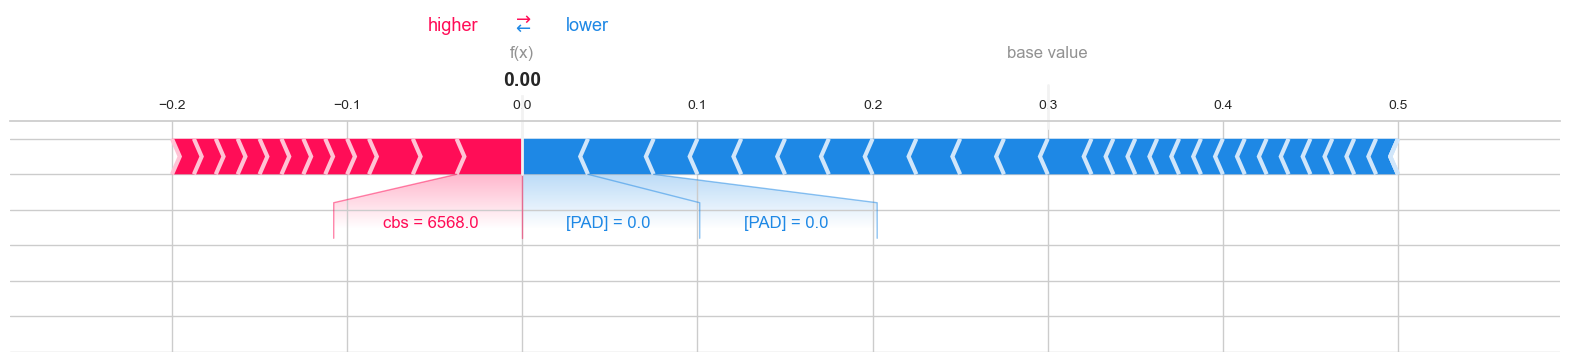

<class 'numpy.ndarray'> [[ 8412 10751  2099  1011  2004 12376  3617  2895  4950  1006  2304  1007
   7823  9233 10751  2099  1011  2004 12376  2895 11082  5959 18378 13433
   2615  3185  5008  8127 11564  3847  1012 10017  2806 16171 10126  3185
  12614  3935  2838  1012  6706 19040  1010  1018  2243  2051  1011 10876
   2063  5425  2191  3733  4569  1012     0     0     0     0     0     0
      0     0     0     0]]
Sentence: sony hd ##r - as ##50 digital action camera ( black ) tough compact hd ##r - as ##50 action lets enjoy playful po ##v movie shooting supplied underwater housing . casual style encourages everyday movie ##making advanced features . steady ##shot , 4 ##k time - laps ##e capture make easy fun . ; Prediction: [1] ; True value: Electronics


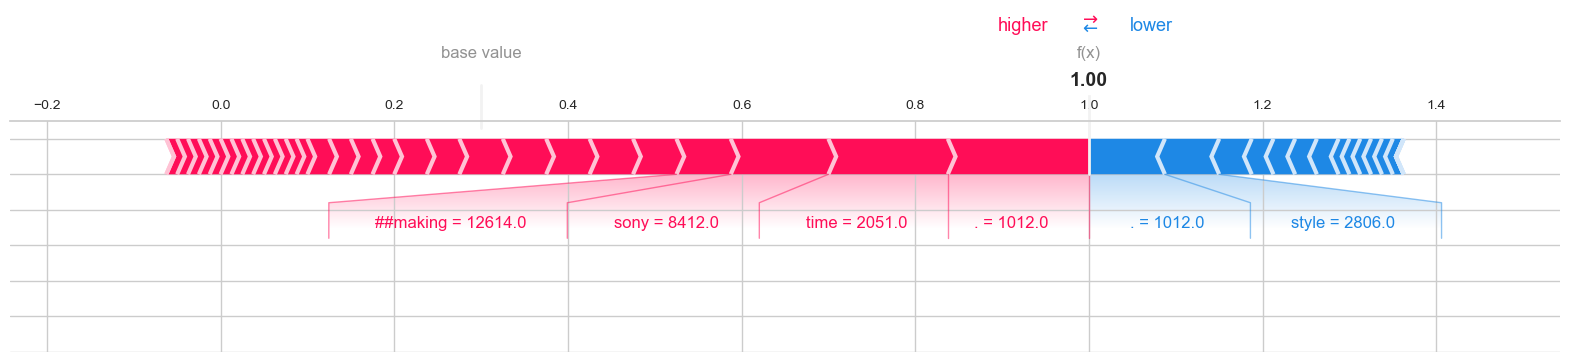

<class 'numpy.ndarray'> [[26742  1039  1011 29065  3617  4950  3638  4003  1016 18259  1060  2094
   1011  3861  4003  1006  1049  1009  2828  1007 26742  1039  1011 29065
   3617  4950  3638  4003  1016 18259  1060  2094  1011  3861  4003  1006
   1049  1009  2828  1007     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: olympus c - 770 digital camera memory card 2 ##gb x ##d - picture card ( m + type ) olympus c - 770 digital camera memory card 2 ##gb x ##d - picture card ( m + type ) ; Prediction: [1] ; True value: Electronics


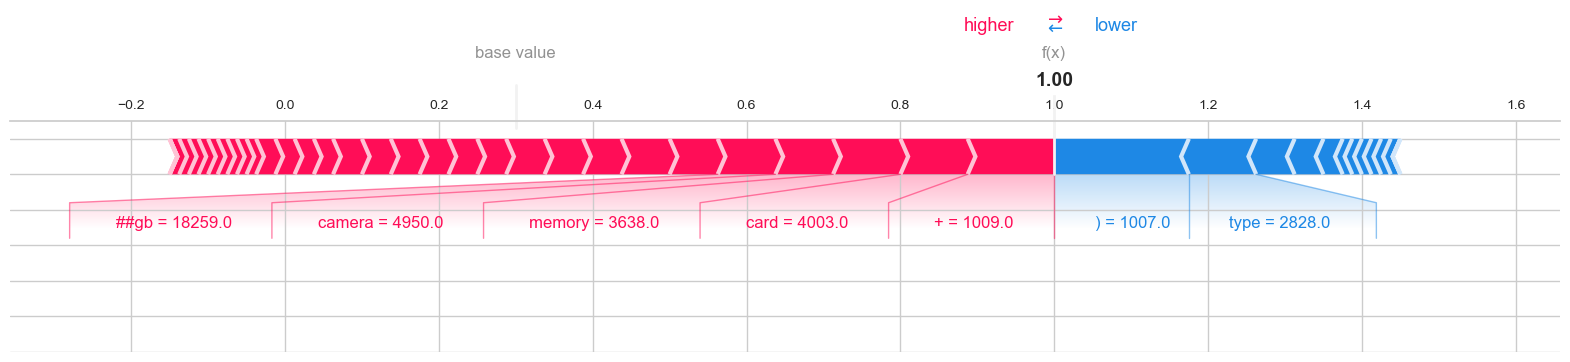

<class 'numpy.ndarray'> [[ 3218  2338  4796  1004  8827  2271  1024  3274  2671  1004  1006 20549
   2692 11338  4160  2015  1007     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: practice book gate & ps ##us : computer science & ( 265 ##0 mc ##q ##s ) ; Prediction: [0] ; True value: Books


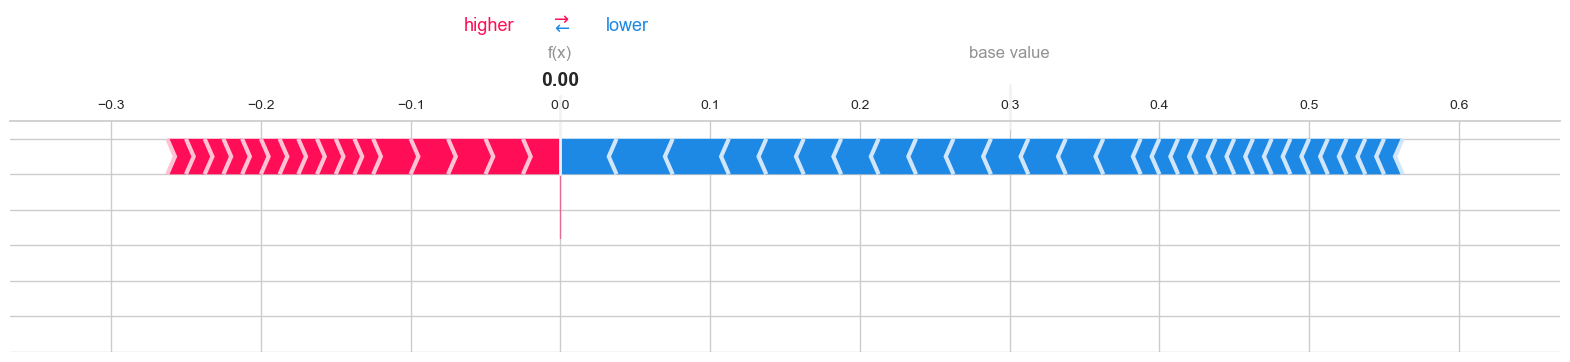

<class 'numpy.ndarray'> [[ 5584 15333  2063     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: physics je ##e ; Prediction: [0] ; True value: Books


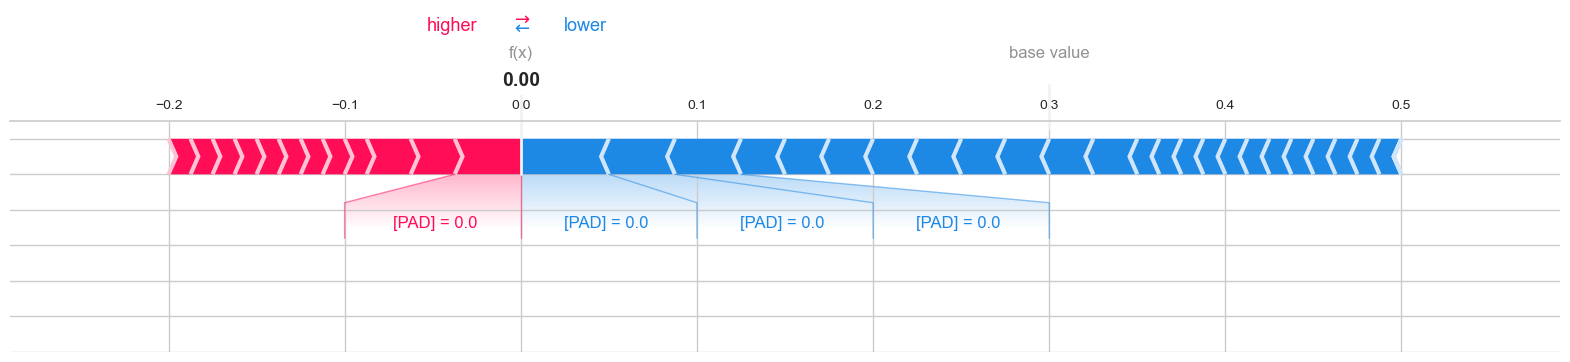

<class 'numpy.ndarray'> [[ 2184  5025  2880  1048 16846 17463 22199  2015  1006  1048 16846  2186
   1007     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: 10 actual official l ##sat prep ##test ##s ( l ##sat series ) ; Prediction: [0] ; True value: Books


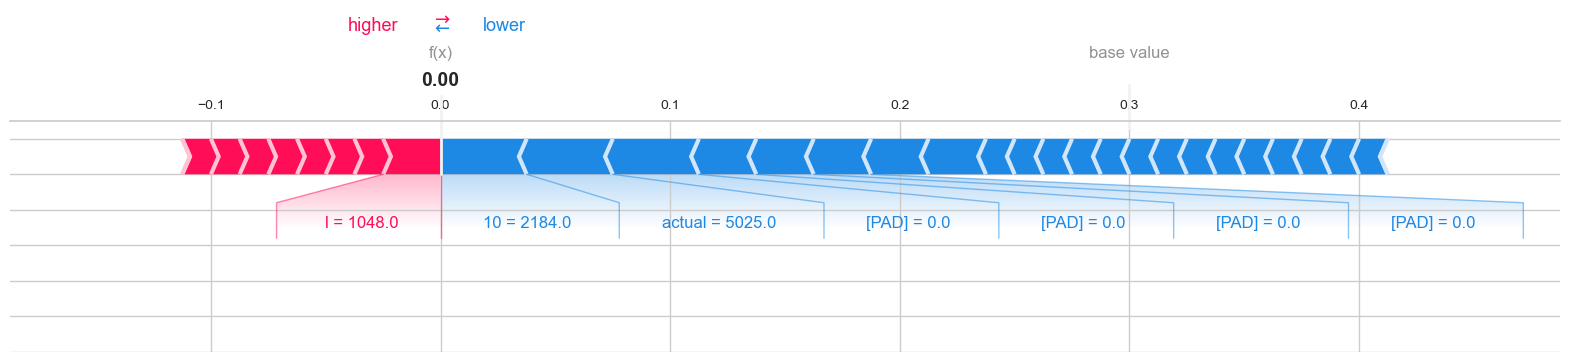

<class 'numpy.ndarray'> [[ 9708  2402  2611  3166  4776  3581 22939 15061  3213  8590  3255  3595
   2088 12558 16762  6254  6394  6139  2762  1012  2446  1011  3644 10563
   1010  2155  1010  3140  6318  1012 12498  9708  1010  9708  2402  2611
   1010  5967  3248  3152  4772  4006  1012     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: diary young girl author anne frank dia ##rist writer transformed pain secret world memoir enduring document nazi occupation germany . german - jewish teenager , family , forced hiding . wartime diary , diary young girl , adapted plays films publication 1947 . ; Prediction: [0] ; True value: Books


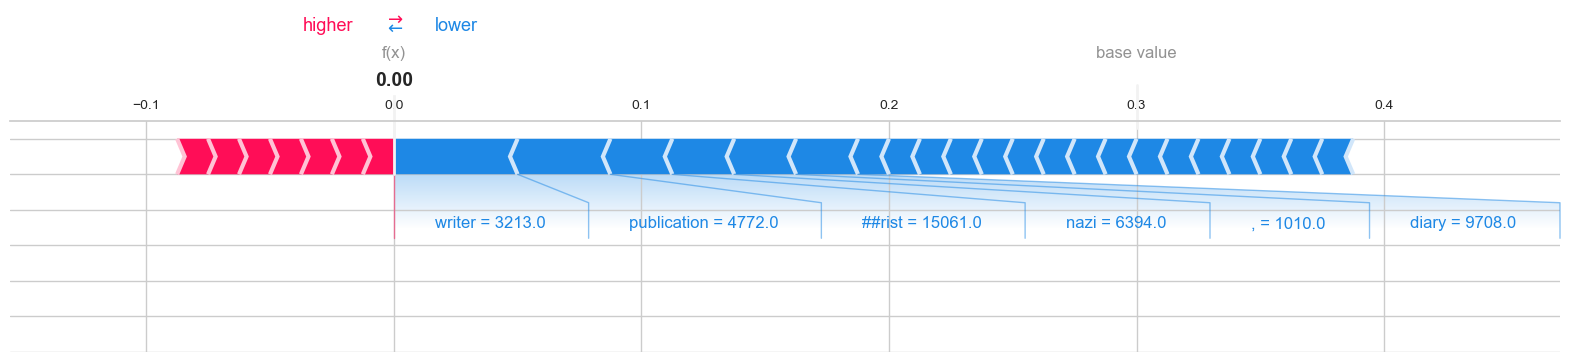

<class 'numpy.ndarray'> [[23889 12702 23035  2015  1011 16432  5543  2465  1011  2260  1011 12606
   2692  2509     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: introductory micro ##economic ##s - textbook economics class - 12 - 121 ##0 ##3 ; Prediction: [0] ; True value: Books


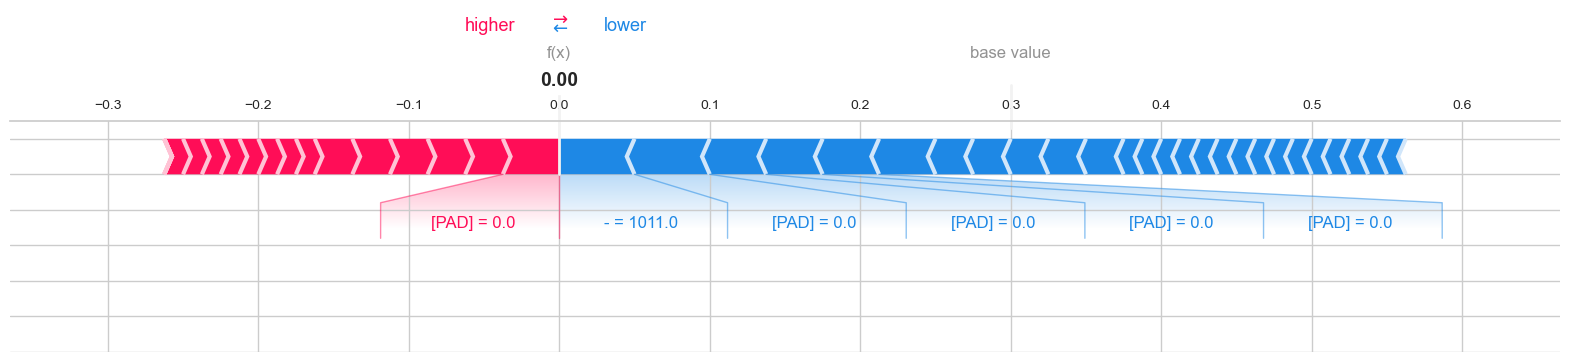

<class 'numpy.ndarray'> [[ 5472 20573 11087 17350  2385 18259  2465  2184 11087 12702 16150  7910
   2015  1011  1045  4003 15581  2121  1006 17371  2015 16211  2099  1011
   5890  2575  2290  1011  1043  2078  2575  2863  1007  2946  2171  1024
   2385 16351  5472 20573 11087 12702 16150  2595  2278  7910  2015  1011
   1045  4003  3819  3405  3666  2440 10751  2678     0     0     0     0
      0     0     0     0]]
Sentence: sand ##isk ultra a1 16 ##gb class 10 ultra micro ##sd uh ##s - i card adapt ##er ( sd ##s ##qua ##r - 01 ##6 ##g - g ##n ##6 ##ma ) size name : 16 gb sand ##isk ultra micro ##sd ##x ##c uh ##s - i card perfect recording watching full hd video ; Prediction: [1] ; True value: Electronics


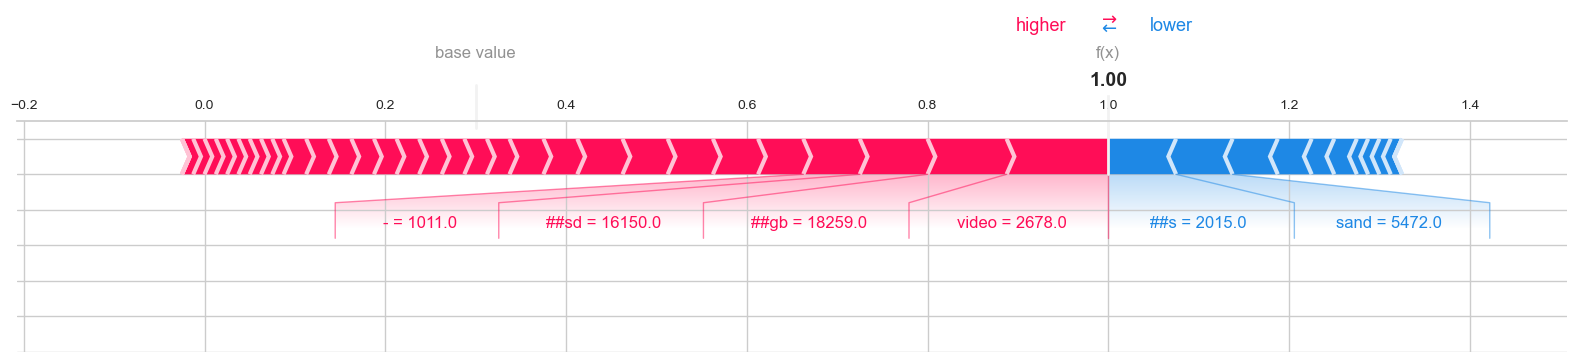

<class 'numpy.ndarray'> [[ 1038 28074 11948  3567  2100 12044  8322     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: b ##harat raj ##va ##y ##vas ##tha ; Prediction: [0] ; True value: Books


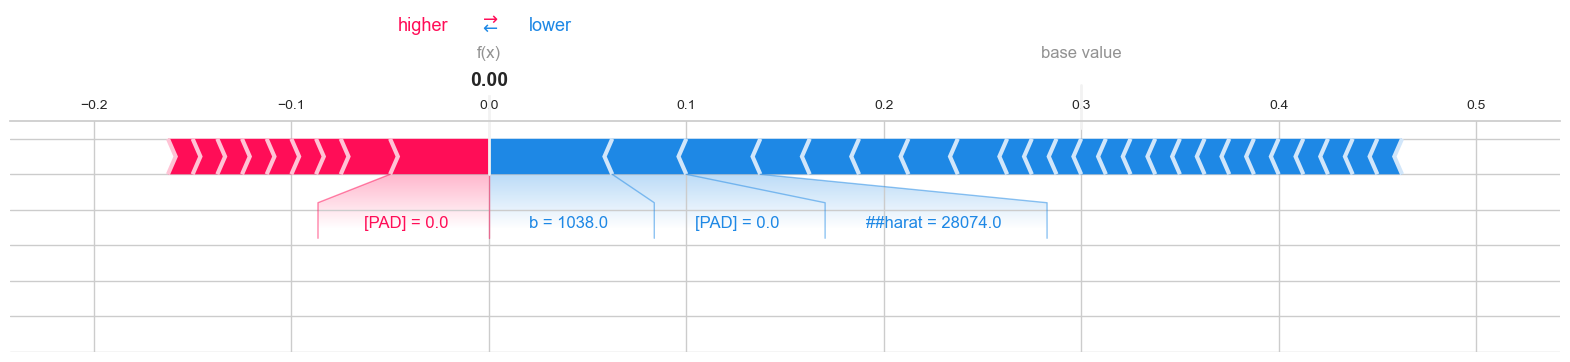

In [24]:
for i in range(len(to_explain)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(to_explain[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([to_explain[i]])), "; True value:", y_test[i])
  shap.plots.force(permutation_values.base_values[i], permutation_values.values[i], permutation_values.data[i], feature_names=tokenizer.convert_ids_to_tokens(permutation_values.data[i]), matplotlib=True)

In [6]:
for i in range(len(permutation_values.values)):
  print(np.sum(permutation_values.values[i]))

-0.3
0.7
0.7
-0.3
-0.3
-0.3
-0.29999999999999993
-0.3
0.7
-0.3


In [74]:
import copy
heatmaps = np.array(copy.copy(permutation_values.values))
heatmaps += 0.3/64
for i in range(len(heatmaps)):
  print(np.sum(heatmaps[i]))

2.7755575615628914e-17
1.0
1.0
-1.3877787807814457e-17
-2.7755575615628914e-17
-1.734723475976807e-17
-6.938893903907228e-18
2.7755575615628914e-17
1.0
-2.7755575615628914e-17


In [75]:
heatmaps

array([[ 0.0421875,  0.0171875,  0.0046875, -0.0203125, -0.0078125,
        -0.0078125, -0.0078125, -0.0078125, -0.0078125, -0.0078125,
         0.0171875,  0.0046875, -0.0078125, -0.0203125, -0.0203125,
         0.0046875, -0.0203125, -0.0203125,  0.0171875,  0.0046875,
         0.0171875,  0.0046875,  0.0171875, -0.0078125, -0.0328125,
        -0.0203125, -0.0078125, -0.0078125, -0.0078125, -0.0203125,
         0.0296875, -0.0078125,  0.0046875,  0.0046875, -0.0203125,
         0.0046875, -0.0203125,  0.0171875,  0.0171875,  0.0171875,
         0.0046875,  0.0046875,  0.0046875, -0.0078125,  0.0046875,
        -0.0328125,  0.0046875, -0.0078125,  0.0296875,  0.0171875,
         0.0046875,  0.0046875,  0.0046875,  0.0046875,  0.0046875,
        -0.0203125,  0.0046875,  0.0046875,  0.0046875,  0.0046875,
         0.0046875,  0.0046875,  0.0046875,  0.0046875],
       [ 0.1171875,  0.0046875,  0.0046875, -0.0078125,  0.0171875,
         0.0171875,  0.0046875,  0.0171875,  0.0546875,  0.

Prediction: Books


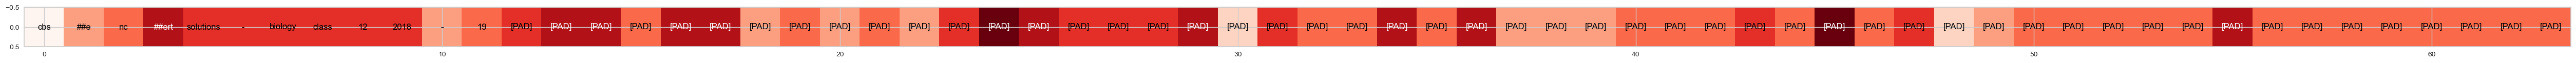

Prediction: Electronics


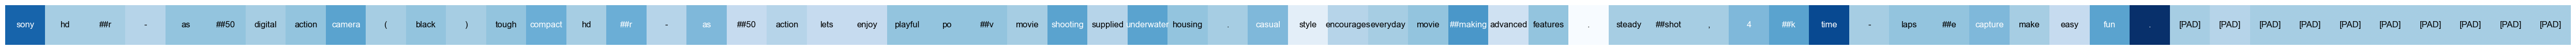

Prediction: Electronics


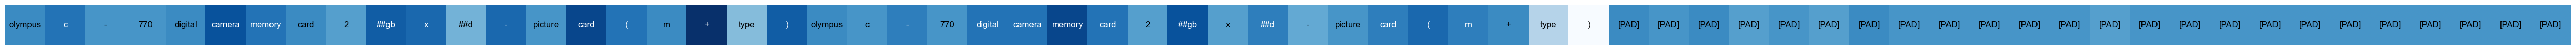

Prediction: Books


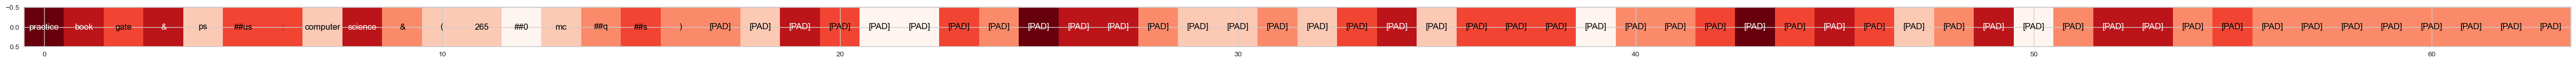

Prediction: Books


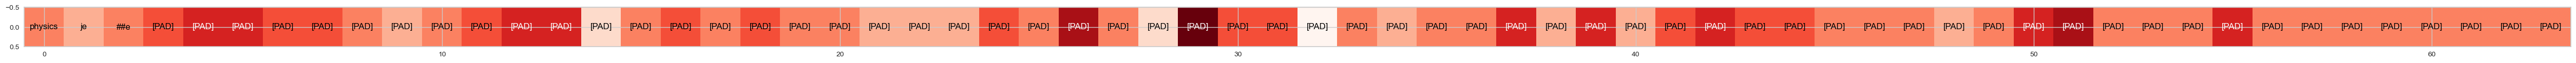

Prediction: Books


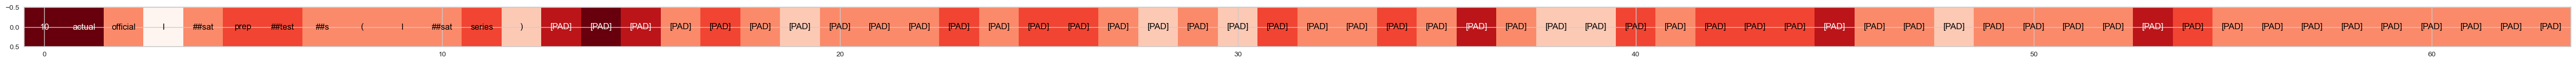

Prediction: Books


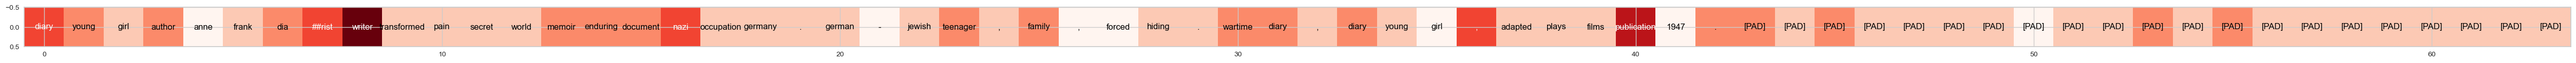

Prediction: Books


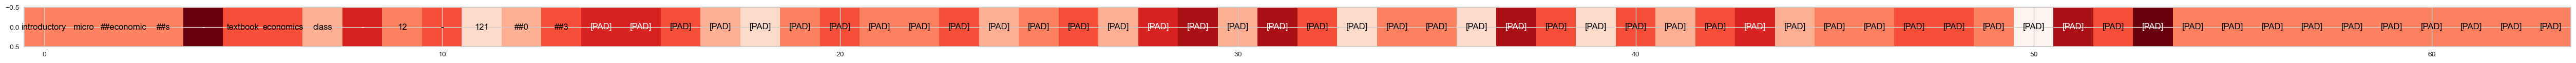

Prediction: Electronics


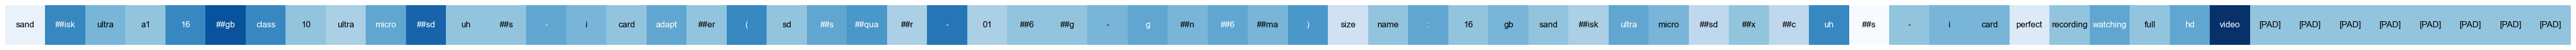

Prediction: Books


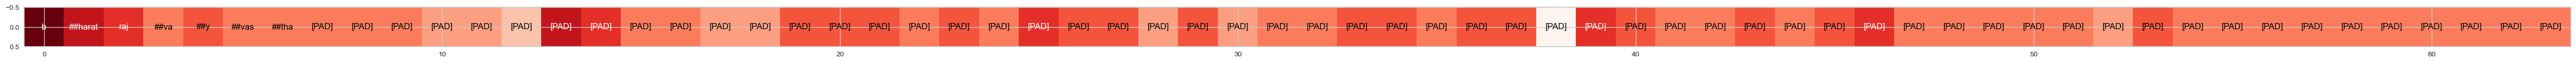

In [84]:
for x in range(len(to_explain)):
  fig, ax = plt.subplots(figsize=(len(to_explain[x]), 1))
  if prediction_model(np.array([to_explain[x]]))[0] == 0:
    print("Prediction: Books")
    ax.imshow([-heatmaps[x]], cmap="Reds", aspect="auto")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] < -0.02 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))
  else:
    print("Prediction: Electronics")
    ax.imshow([heatmaps[x]], cmap="Blues", aspect="auto")
    ax.axis("off")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] > 0.02 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))


  plt.show()

In [85]:
import dill
filename = 'globalsave.pkl'
dill.dump_session(filename)

# and to load the session again:
# dill.load_session(filename)